In [55]:
%matplotlib inline
%config InlineBackend.figure_formats=['svg']
import csv
import io
import urllib.request
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timedelta
from matplotlib.dates import date2num

In [47]:
def data_scrap(ID, date):
    #Scrap weather data of given location and given period of time from websites
    #ID is a string contains weather station ID
    #date is a 1 by 3 string array: Month/Date/Year

    data_temp=[] #Stores raw data from the weather station
    str1 = 'https://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID='
    str2 = '&day='
    str3 = '&month='
    str4 = '&year='
    str5 = '&graphspan=day&format=1'
    url = str1+ID+str2+date[1]+str3+date[0]+str4+date[2]+str5
    response = urllib.request.urlopen(url)
    cr=csv.reader(io.TextIOWrapper(response))
    for row in cr:
        if len(row)<= 1: continue
        data_temp.append(row)
    
    #Stores data with correct data type (datetime/string/double)
    data = [[0 for i in range(len(data_temp[1][:])-3)] for j in range(len(data_temp))]

    for i in range(len(data_temp)):
        if i == 0:
            data[0][:]=data_temp[0][0:len(data_temp[i][:])-2]
        elif i > 0:
            data[i][0]=datetime.strptime(data_temp[i][0], '%Y-%m-%d %H:%M:%S')
            data[i][1:data_temp[0][:].index('WindDirection')]=tuple(float(list_item) for list_item in data_temp[i][1:data_temp[0][:].index('WindDirection')])
            data[i][data_temp[0][:].index('WindDirection')] = data_temp[i][data_temp[0][:].index('WindDirection')]
            data[i][data_temp[0][:].index('WindDirection')+1:data_temp[0][:].index('Conditions')] = tuple(float(list_item) for list_item in data_temp[i][data_temp[0][:].index('WindDirection')+1:data_temp[0][:].index('Conditions')])
            data[i][data_temp[0][:].index('Conditions'):data_temp[0][:].index('Clouds')+1] = data_temp[i][data_temp[0][:].index('Conditions'):data_temp[0][:].index('Clouds')+1]
            data[i][data_temp[0][:].index('Clouds')+1:len(data_temp[0][:])-2] = tuple(float(list_item) for list_item in data_temp[i][data_temp[0][:].index('Clouds')+1:len(data_temp[i][:])-3])
    
    #Select data for csv file(Date,Temperature, Pressure, Windspeed, Humidity, Hourly Precipitation, and Solar radiation)
    data_csv = [[0 for i in range(7)] for j in range(len(data))]

    for i in range(len(data_temp)):
        data_csv[i][0:2] = data[i][0:2]
        data_csv[i][2] = data[i][3]
        data_csv[i][3] = data[i][6]
        data_csv[i][4:6] = data[i][8:10]
        data_csv[i][6] = data[i][13]
    
    #Store data as a csv file locally (in current directory)
    path = os.getcwd() + ID + '.csv'
    with open(path,'w',newline='') as f:
        csv_file = csv.writer(f, delimiter=',')
        for row in data_csv:
            csv_file.writerow(row)

    return data_csv, csv_file

In [48]:
def findNearestDate(alist,date,delta):
    #Binary search to find the nearest datetime within tolerance in a list given a specific date
    #Delta is the tolerance
    #Recursion
    
    midpoint = (len(alist)-1)//2 
    
    if midpoint < 0:
        return None
    else:
        if abs(alist[midpoint]-date) < delta:
                return alist[midpoint]
        else:
                if date < alist[midpoint]:
                    return findNearestDate(alist[0:midpoint],date,delta)
                else:
                    return findNearestDate(alist[midpoint+1:],date,delta)

In [49]:
def mergeData(raw_date, CPM, date):
    #Merge radiation data to weather data; raw_date and CPM are from radiation data
    #Each time in date list is matched up with the nearest date in raw_date list
    
    delta = timedelta(minutes=5)
    merge = [0 for i in range(len(date))]

    for i in range (len(date)):
        new_date = findNearestDate(raw_date,date[i],delta)
        merge[i] = CPM[raw_date.index(new_date)]
            
 
    return merge

In [50]:
def calculateCorrelationCoefficient(data_x, data_y):
    #Correlation Coefficient:(r)
    #r = sum((x(i)-x_avg)*(y(i)-y_avg))/sqrt( sum( (x(i)-x_avg)^2 )*sum( (y(i)-y_avg)^2 ) )
    #Variance = (standard deviation)^2
    sum_x = 0
    sum_y = 0
    sum_xy = 0
    x_var = 0
    y_var = 0
    x_avg = sum(data_x)/len(data_x)
    y_avg = sum(data_y)/len(data_y)

    for i in range(0,len(data_x)):
        sum_xy += (data_x[i]-x_avg) * (data_y[i]-y_avg)
        sum_x += (data_x[i]-x_avg)*(data_x[i]-x_avg)
        sum_y += (data_y[i]-y_avg)*(data_y[i]-y_avg)
    
    x_var = np.sqrt(sum_x/(len(data_x)-1))
    y_var = np.sqrt(sum_y/(len(data_y)-1))
    r = sum_xy/np.sqrt(sum_x*sum_y)
    return r, x_var, y_var,x_avg,y_avg

In [51]:
#Test Case: 2016/5/19
start = ['5','19','2016']
location = 'KCABERKE89'
data, csv_file =data_scrap(location, start)
        
#Import data from LBL device
L_date = []
L_CPM = []
line = 0
url = 'http://radwatch.berkeley.edu/sites/default/files/dosenet/lbl.csv'
response = urllib.request.urlopen(url)
            
reader=csv.reader(io.TextIOWrapper(response))
for row in reader:
    if line != 0:
        L_date.append(datetime.strptime(row[0],'%Y-%m-%d %H:%M:%S'))
        L_CPM.append(float(row[1]))
    line += 1
       
#Import data from weather station
date = []
temperature = []
pressure = []
windSpeed = []
humidity = []
hourPrecep = []
solarRadiation = []
line = 0
for row in data:
    #skip first row (row that specifies fields)
    if line != 0:
        date.append(row[0])
        temperature.append(row[1])
        pressure.append(row[2])
        windSpeed.append(row[3])
        humidity.append([4])
        hourPrecep.append(row[5])
        solarRadiation.append(row[6])
    line += 1


In [52]:
#Modify LBL data according to weather station
delta = timedelta(minutes=5)
min_date_index = L_date.index(findNearestDate(L_date, date[0],delta))
max_date_index = L_date.index(findNearestDate(L_date, date[-1],delta))
merge = mergeData(L_date[min_date_index:max_date_index+1], L_CPM[min_date_index:max_date_index+1], date)

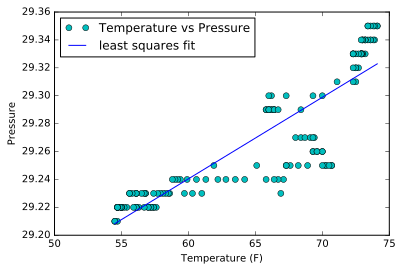

In [59]:
#Example 1: Determine correlation coefficient between two sets of data (Temperature vs Pressure)
r,t_var,p_var, t_avg, p_avg = calculateCorrelationCoefficient(temperature, pressure)

slope = r*p_var/t_var #slope = r*var_y/var_x
intercept = p_avg-slope*t_avg #intercept = <Y> - slope*<X>

fig, ax = plt.subplots()
plt.plot(temperature,pressure, 'co', label="Temperature vs Pressure")

#Plot least sqaures fit function (y = mx+b)
polynomial = np.poly1d([slope, intercept])
fit = polynomial(temperature)
plt.plot(temperature, fit, label="least squares fit")

#Plot legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=2)

plt.xlabel('Temperature (F)')
plt.ylabel('Pressure')


plt.show()

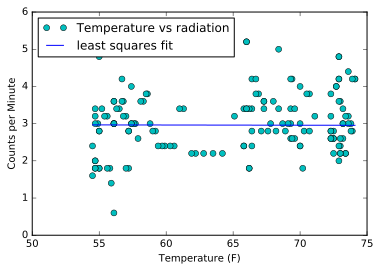

In [34]:
#Example 2: Determining correlation between temperature and radiation data
r,t_var,l_var, t_avg, l_avg = calculateCorrelationCoefficient(temperature, L_CPM)
slope = r*l_var/t_var
intercept = l_avg-slope*t_avg
fig, ax = plt.subplots()
plt.plot(temperature,merge, 'co', label="Temperature vs radiation")
                
#Plot least squares fit function (y = mx+b)
polynomial = np.poly1d([slope, intercept])
fit = polynomial(temperature)
plt.plot(temperature, fit, label="least squares fit") 

#Make legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=2)

plt.xlabel('Temperature (F)')
plt.ylabel('Counts per Minute')

plt.show()

In [35]:
#Plot each set of data against time
#All data share the same x axis
fig, ax = plt.subplots(7, sharex=True)
ax[0].plot(date2num(date),temperature,'r-o',label='Temperature')
ax[1].plot(date2num(date),temperature,'r-o',label='Pressure')
ax[2].plot(date2num(date),windSpeed,'r-o',label='Wind Speed')
ax[3].plot(date2num(date),humidity,'r-o',label='Humidity')
ax[4].plot(date2num(date),hourPrecep,'r-o',label='Hourly Precipitation')
ax[5].plot(date2num(date),solarRadiation,'r-o',label = 'Solar Radiation')
ax[6].plot(date2num(date),merge,'r-o',label = 'CPM')

#Make legends
for i in range (7):
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend(handles, labels, loc = 0)

#Scale x axis
ax[0].xaxis.set_major_locator(mdates.HourLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax[0].xaxis.set_minor_locator(mdates.MinuteLocator())
ax[0].set_xlim(date[0],date[-1])
ax[0].fmt_xdata = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')

#Rotate and right align the x labels
fig.autofmt_xdate()

plt.xlabel('Time')

plt.show()